# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
**In part 5**

We have demonstrated the possible and colateral leakage of a trained model, but recall that we're most interested in Functional Encryption, and this means that all numbers sould actually be **integers** or at least **fixed precision** tensors. We'll leverage here the PySyft library which provides a way to directly use PyTorch in a fixed precision scheme!

# 4 Quadratic model to fix precision


Let's define the precision fractional to be quite high, and we'll change it as we go.

In [1]:
PREC_FRAC = 5

Load torch and syft packages

In [2]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [3]:
import torch
import syft as sy
hook = sy.TorchHook(torch)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from learn import main, train, test, show_results, show_confusion_matrix

Let's load the quadratic model that we saved in Part 4! _Be sure that the path and file name match._

In [5]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)
    
    def transform(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

In [6]:
model = QuadNet(26)
path = '../data/models/quad_char.pt'
model.load_state_dict(torch.load(path))
model.eval()

QuadNet(
  (proj1): Linear(in_features=784, out_features=50, bias=True)
  (diag1): Linear(in_features=50, out_features=26, bias=True)
)

We will now convert the model into fixed precision, look how the `diag1.bias` changes for example!

In [7]:
model.diag1.bias

Parameter containing:
tensor([-0.0022,  0.0088,  0.0200, -0.0146,  0.0012,  0.0115,  0.0167,  0.0181,
        -0.0106,  0.0199,  0.0095, -0.0058,  0.0165, -0.0008,  0.0002,  0.0111,
         0.0100,  0.0019,  0.0137, -0.0397, -0.0195, -0.0252, -0.0009, -0.0057,
         0.0029,  0.0196], requires_grad=True)

In [8]:
model.fix_precision(precision_fractional=PREC_FRAC)

QuadNet(
  (proj1): Linear(in_features=784, out_features=50, bias=True)
  (diag1): Linear(in_features=50, out_features=26, bias=True)
)

In [9]:
print(model.diag1.bias)

Parameter>FixedPrecisionTensor>tensor([ -220,   882,  1996, -1458,   121,  1154,  1670,  1811, -1055,  1990,
          948,  -577,  1648,   -84,    17,  1112,   997,   193,  1365, -3973,
        -1948, -2521,   -86,  -569,   289,  1961])


We now define the components which are necessary for performing an evaluation

In [10]:
import learn

In [11]:
class Parser:
    """Parameters for the testing"""
    def __init__(self):
        self.test_batch_size = 1000

And we load the data!

In [12]:
torch.manual_seed(1)
args = Parser()

data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
test_target = test_target_char
test_dataset = learn.build_tensor_dataset(test_data, test_target)
test_loader = utils.DataLoader(
    test_dataset,
    batch_size=args.test_batch_size, shuffle=True
)

Training set 60000 items
Testing set  10000 items


Here comes the test phase, which in very close to `learn.test`. However, as you see we convert the data into fixed precision, and instead of a full forward pass, we omit the last log_softmax (by using `.transform()`) as it should not be applied in the encryption part so not be applied on the integers. Hence, we apply it after the output is converted back to float.

In [13]:
def test(model, test_loader, prec_frac):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data.fix_precision_(precision_fractional=prec_frac) # <-- This is new
            output = model.transform(data) # <-- Not calling forward to avoid the log_softmax
            output = output.float_precision() # <-- This is new
            output = F.log_softmax(output, 1) # <-- put the log_softmax now
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    return acc

test(model, test_loader, PREC_FRAC)



Test set: Average loss: 0.0002, Accuracy: 9523/10000 (95.23%)



95.23

So the accuracy remains very good!
Let's now change `PREC_FRAC` parameter to reduce the precision and observe what is the minimum precision we need to keep.

In [14]:
prec_accuracy = {}
for prec_frac in range(1, 7):
    # THIS IS BECAUSE THE HOOK_ARGS KEEPS IN MEMORY THE FRAC PRECISION
    sy.frameworks.torch.hook_args.hook_method_response_functions = {}
    
    model = QuadNet(26)
    model.load_state_dict(torch.load(path))
    model.eval()
    model.fix_precision(precision_fractional=prec_frac)
    
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    acc = test(model, test_loader, prec_frac)
    print('prec', prec_frac, 'acc', acc)
    prec_accuracy[prec_frac] = acc


Test set: Average loss: 0.0033, Accuracy: 500/10000 (5.00%)

prec 1 acc 5.0

Test set: Average loss: 0.0003, Accuracy: 8881/10000 (88.81%)

prec 2 acc 88.81

Test set: Average loss: 0.0002, Accuracy: 9512/10000 (95.12%)

prec 3 acc 95.12

Test set: Average loss: 0.0002, Accuracy: 9523/10000 (95.23%)

prec 4 acc 95.23

Test set: Average loss: 0.0002, Accuracy: 9523/10000 (95.23%)

prec 5 acc 95.23

Test set: Average loss: 0.0002, Accuracy: 9522/10000 (95.22%)

prec 6 acc 95.22


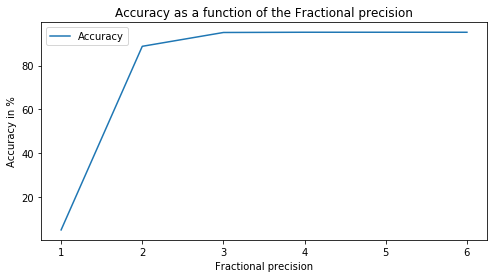

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(prec_accuracy.keys(), prec_accuracy.values(), label='Accuracy')
plt.ylabel('Accuracy in %')
plt.xlabel('Fractional precision')
plt.title('Accuracy as a function of the Fractional precision')
plt.legend()
plt.show()

As you observe, setting the fractional precision to 3 is far enough to have a very good accuracy compared to the best achievable.

Cool! Next question is: how does this impact the collateral learning? Response in Part 6!